# About the Project:

- Neuromarketing has gained significance in the recent years due to its ability to predict customer responses
 and decision making during a purchase. 
 - The outcomes of
 neuromarketing studies can provide insights to the marketing
 companies regarding the customers’ thinking and preferences,
 thereby enhancing their marketing strategies. 
 - This study uses data from the *NeuroBioSense* dataset. 
 - It focuses on determining the effectiveness of PPG (Blood Volume Pulse) in classifying
 emotions. 
 - The emotions are classified into low and high arousal, and low and high valence states based on the Circumplex
 model of emotions. 
 - The time, frequency and HRV features are extracted and used in classifying the arousal and valence
 classes using an **XGBoost** classifier. 
 - The combination of time, frequency and HRV features yielded an average accuracy of 71% for arousal emotions classification and 55% for valence
 emotions classification. 
 - The proposed approach provides data driven insights into consumer engagement, offering valuable implications for emotionally adaptive marketing.

## Valence Classification

In [ ]:
# Imports
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

##### Filter (Adjust Filter Settings here)

In [2]:
from scipy.signal import butter, filtfilt

# --- Butterworth Bandpass Filter Function ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

# --- Apply Butterworth Filter ---
fs = 32  # sampling rate
lowcut = 0.5
highcut = 5.0

b, a = butter_bandpass(lowcut, highcut, fs, order=4)

# Use bvp_filtered in place of raw `bvp` from here on

##### Function definitions

In [6]:
# --- Parameters ---
WINDOW_SIZE = 160
STEP_SIZE = 160
FS = 32.0  # Sampling frequency in Hz

# --- Butterworth filter ---
def butterworth_filter(signal, order=4, cutoff=3.0, fs=32.0):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)


# --- Frequency-domain features ---
def extract_frequency_features(segment, fs=32.0):
    n = len(segment)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_vals = np.fft.rfft(segment)
    power = np.abs(fft_vals) ** 2

    low_band = (freqs >= 0) & (freqs < 0.15)
    mid_band = (freqs >= 0.15) & (freqs < 0.5)
    high_band = (freqs >= 0.5) & (freqs < 1.5)

    low_power = np.sum(power[low_band])
    mid_power = np.sum(power[mid_band])
    high_power = np.sum(power[high_band])
    total_power = np.sum(power)
    dominant_freq = freqs[np.argmax(power)]

    return [low_power, mid_power, high_power, total_power, dominant_freq]

# --- HRV features from a BVP segment ---
def extract_hrv_features(segment, fs=32.0):

    # Peak detection with basic thresholding
    distance = int(0.4 * fs)  # ~40 bpm
    peaks, _ = find_peaks(segment, distance=distance)

    if len(peaks) < 2:
        return [0] * 6  # fallback if no valid peaks

    ibi = np.diff(peaks) / fs  # inter-beat intervals in seconds
    ibi_ms = ibi * 1000        # convert to ms

    rmssd = np.sqrt(np.mean(np.square(np.diff(ibi_ms)))) if len(ibi_ms) > 1 else 0
    nn50 = np.sum(np.abs(np.diff(ibi_ms)) > 50)
    pnn50 = nn50 / len(ibi_ms) if len(ibi_ms) > 0 else 0
    # hr = 60.0 / np.mean(ibi) if np.mean(ibi) > 0 else 0

    return [
        np.mean(ibi_ms),
        np.std(ibi_ms),   
    ]

In [4]:
# LIST of Feature names

feature_names = [
    # Statistical features
    "mean", "std", "min", "max", "skew", "kurtosis", "median", "range",

    # Frequency-domain features
    "low_power", "mid_power", "high_power", "total_power", "dominant_freq",

    # HRV features
    "IBI_mean", "IBI_std"
]

In [ ]:
# PRE-PROCESS DATA
# --- Load and preprocess data ---
df = pd.read_csv(r"C:\......\ppg_with_valence_arousal.csv")
df = df[df['valence'].notna()]
df = df[df['valence'] != 'N']
df = df.reset_index(drop=True)

bvp = df['BVP'].values
bvp_filtered = butterworth_filter(bvp, fs=FS)
labels = df['valence'].values

le = LabelEncoder()
y_full = le.fit_transform(labels)

In [8]:
# FEATURE EXTRACTION
# --- Segment and extract features ---
features = []
y_segments = []

for i in range(0, len(bvp_filtered) - WINDOW_SIZE + 1, STEP_SIZE):
    segment = bvp_filtered[i:i + WINDOW_SIZE]
    label = y_full[i + WINDOW_SIZE // 2]

    # Time-domain features
    stats_features = [
        np.mean(segment),
        np.std(segment),
        np.min(segment),
        np.max(segment),
        skew(segment),
        kurtosis(segment),
        np.median(segment),
        np.max(segment) - np.min(segment),
    ]

    # Frequency-domain
    freq_features = extract_frequency_features(segment, fs=FS)

    # HRV features
    hrv_features = extract_hrv_features(segment, fs=FS)

    full_features = stats_features+freq_features + hrv_features
    
    features.append(full_features)
    y_segments.append(label)

X = np.array(features)
y = np.array(y_segments)

print(f"Created {len(X)} segments with {X.shape[1]} features each.")
print(f"Class distribution before balancing: {Counter(y)}")

# --- Balance classes ---
X_LV = X[y == 0]
y_LV = y[y == 0]
X_HV = X[y == 1]
y_HV = y[y == 1]

min_size = min(len(X_LV), len(X_HV))
X_LV = X_LV[:min_size]
y_LV = y_LV[:min_size]
X_HV = X_HV[:min_size]
y_HV = y_HV[:min_size]

X_balanced = np.vstack((X_LV, X_HV))
y_balanced = np.concatenate((y_LV, y_HV))

print(f"Class distribution after balancing: {Counter(y_balanced)}")

Created 4471 segments with 15 features each.
Class distribution before balancing: Counter({np.int64(0): 2780, np.int64(1): 1691})
Class distribution after balancing: Counter({np.int64(0): 1691, np.int64(1): 1691})


In [9]:
# TRAINING MODEL

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# --- Train XGBoost ---
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.5318
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       370
           1       0.49      0.60      0.54       307

    accuracy                           0.53       677
   macro avg       0.54      0.54      0.53       677
weighted avg       0.54      0.53      0.53       677

Confusion Matrix:
[[176 194]
 [123 184]]


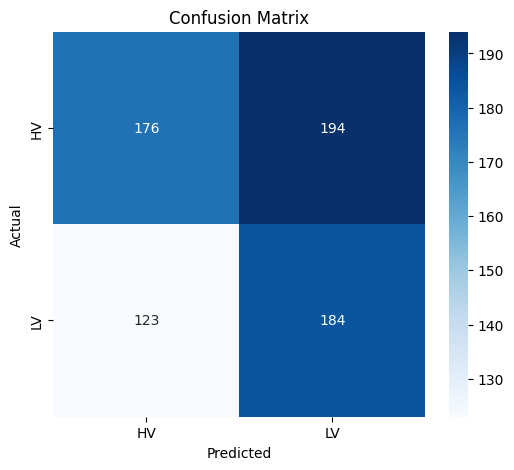

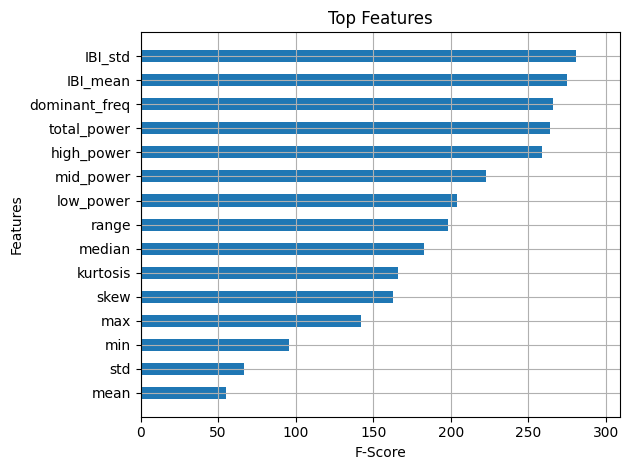

In [10]:
# METRICS AND PLOTS

# --- Predict and Evaluate ---
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Feature Importance ---
xgb.plot_importance(
    xgb_model,
    max_num_features=15,
    importance_type='weight',
    title='Top Features',
    xlabel='F-Score',
    height=0.5,
    show_values=False
)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.tight_layout()
plt.show()

# Arousal Classification

In [11]:
# Imports

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [12]:
# FUNCTION Definitions

# --- Parameters ---
WINDOW_SIZE = 160
STEP_SIZE = 160
FS = 32.0  # Sampling frequency in Hz

# --- Butterworth filter ---
def butterworth_filter(signal, order=4, cutoff=3.0, fs=32.0):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

feature_names = [
    # Statistical features
    "mean", "std", "min", "max", "skew", "kurtosis", "median", "range",

    # Frequency-domain features
    "low_power", "mid_power", "high_power", "total_power", "dominant_freq",

    # HRV features
    "IBI_mean", "IBI_std"
]

# --- Frequency-domain features ---
def extract_frequency_features(segment, fs=32.0):
    n = len(segment)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_vals = np.fft.rfft(segment)
    power = np.abs(fft_vals) ** 2

    low_band = (freqs >= 0) & (freqs < 0.15)
    mid_band = (freqs >= 0.15) & (freqs < 0.5)
    high_band = (freqs >= 0.5) & (freqs < 1.5)

    low_power = np.sum(power[low_band])
    mid_power = np.sum(power[mid_band])
    high_power = np.sum(power[high_band])
    total_power = np.sum(power)
    dominant_freq = freqs[np.argmax(power)]

    return [low_power, mid_power, high_power, total_power, dominant_freq]


# --- HRV features from a BVP segment ---
def extract_hrv_features(segment, fs=32.0):

    # Peak detection with basic thresholding
    distance = int(0.4 * fs)  # ~40 bpm
    peaks, _ = find_peaks(segment, distance=distance)

    if len(peaks) < 2:
        return [0] * 6  # fallback if no valid peaks

    ibi = np.diff(peaks) / fs  # inter-beat intervals in seconds
    ibi_ms = ibi * 1000        # convert to ms

    rmssd = np.sqrt(np.mean(np.square(np.diff(ibi_ms)))) if len(ibi_ms) > 1 else 0
    nn50 = np.sum(np.abs(np.diff(ibi_ms)) > 50)
    pnn50 = nn50 / len(ibi_ms) if len(ibi_ms) > 0 else 0
    hr = 60.0 / np.mean(ibi) if np.mean(ibi) > 0 else 0

    return [
        np.mean(ibi_ms),
        np.std(ibi_ms),  
    ]

In [ ]:
# PRE-PROCESS DATA

# --- Load and preprocess data ---
df = pd.read_csv(r"C:\......\ppg_with_valence_arousal.csv")
df = df[df['arousal'].notna()]
df = df[df['arousal'] != 'N']
df = df.reset_index(drop=True)

bvp = df['BVP'].values
bvp_filtered = butterworth_filter(bvp, fs=FS)
labels = df['arousal'].values

le = LabelEncoder()
y_full = le.fit_transform(labels)

In [14]:
# FEATURE EXTRACTION

# --- Segment and extract features ---
features = []
y_segments = []

for i in range(0, len(bvp_filtered) - WINDOW_SIZE + 1, STEP_SIZE):
    segment = bvp_filtered[i:i + WINDOW_SIZE]
    label = y_full[i + WINDOW_SIZE // 2]

    # Time-domain features
    stats_features = [
        np.mean(segment),
        np.std(segment),
        np.min(segment),
        np.max(segment),
        skew(segment),
        kurtosis(segment),
        np.median(segment),
        np.max(segment) - np.min(segment),
    ]

    # Frequency-domain
    freq_features = extract_frequency_features(segment, fs=FS)

    # HRV features
    hrv_features = extract_hrv_features(segment, fs=FS)

    full_features = stats_features+ freq_features + hrv_features
    features.append(full_features)
    y_segments.append(label)

X = np.array(features)
y = np.array(y_segments)

print(f"Created {len(X)} segments with {X.shape[1]} features each.")
print(f"Class distribution before balancing: {Counter(y)}")

# --- Balance classes ---
X_LV = X[y == 0]
y_LV = y[y == 0]
X_HV = X[y == 1]
y_HV = y[y == 1]

min_size = min(len(X_LV), len(X_HV))
X_LV = X_LV[:min_size]
y_LV = y_LV[:min_size]
X_HV = X_HV[:min_size]
y_HV = y_HV[:min_size]

X_balanced = np.vstack((X_LV, X_HV))
y_balanced = np.concatenate((y_LV, y_HV))

print(f"Class distribution after balancing: {Counter(y_balanced)}")

Created 6694 segments with 15 features each.
Class distribution before balancing: Counter({np.int64(0): 6268, np.int64(1): 426})
Class distribution after balancing: Counter({np.int64(0): 426, np.int64(1): 426})


In [15]:
# TRAIN MODEL

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# --- Train XGBoost ---
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.7076
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        88
           1       0.71      0.67      0.69        83

    accuracy                           0.71       171
   macro avg       0.71      0.71      0.71       171
weighted avg       0.71      0.71      0.71       171

Confusion Matrix:
[[65 23]
 [27 56]]


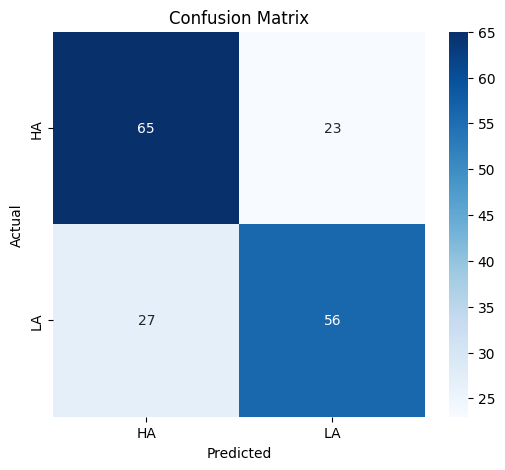

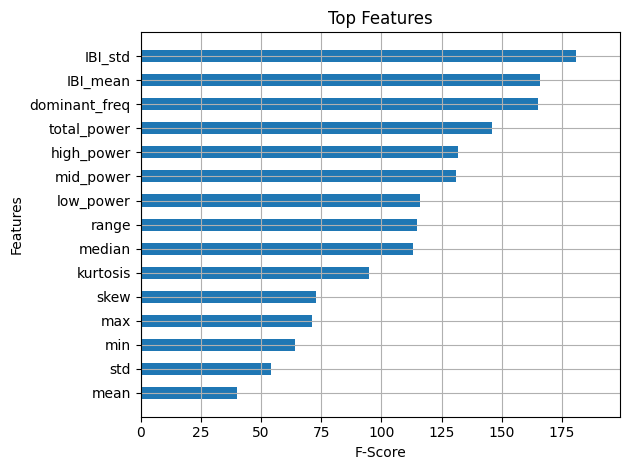

In [16]:
# Metrics and Plotting

# --- Predict and Evaluate ---
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Feature Importance ---
xgb.plot_importance(
    xgb_model,
    max_num_features=15,
    importance_type='weight',
    title='Top Features',
    xlabel='F-Score',
    height=0.5,
    show_values=False
)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.tight_layout()
plt.show()


-------------------------------------------------------------------------END of Code---------------------------------------------------------------------------------------------------